<a href="https://colab.research.google.com/github/mjacob75/PowerGrid/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

plt.rcParams['figure.figsize'] = [12, 6]

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

plt.rcParams['figure.figsize'] = [12, 6]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!






/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Selecting only digits 0,..,MaxLabels to reduce computational complexity

In [ ]:
MaxLabels = 10
mnist_data_reduced = mnist_data
idx = mnist_data.train_labels<MaxLabels
mnist_data_reduced.data = mnist_data.data[idx]
mnist_data_reduced.targets = mnist_data.targets[idx]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32,base_size=64):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = 64


        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

In [ ]:
class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32,base_size=64):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = 64

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x


In [ ]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [ ]:
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.gpu_mode = params['gpu']
        self.input_size = 28
        self.z_dim = params['z_dim']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(mnist_data_reduced, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()
            self.BCE_loss = nn.BCELoss().cuda()
        else:
            self.BCE_loss = nn.BCELoss()

        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
                
            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                  self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

  # display results
    def visualize_results(self, epoch, fix=True):
      self.G.eval()
      sample_z_ = torch.rand((10, self.z_dim))
      if self.gpu_mode:
        sample_z_ = sample_z_.cuda()
      samples = self.G(sample_z_)

      if self.gpu_mode:
        samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      else:
        samples = samples.data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
        s=ax[i].imshow(np.squeeze(samples[i,]))
        s=ax[i].get_xaxis().set_visible(False)
        s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()


training start!!
Epoch: [ 1] [  50/ 200] D_loss: 1.30954468, G_loss: 0.89106733
Epoch: [ 1] [ 100/ 200] D_loss: 1.15408957, G_loss: 0.94401014
Epoch: [ 1] [ 150/ 200] D_loss: 1.11729527, G_loss: 0.95914704
Epoch: [ 1] [ 200/ 200] D_loss: 1.00826132, G_loss: 0.97234726


<Figure size 72x720 with 0 Axes>

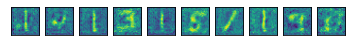

Epoch: [ 2] [  50/ 200] D_loss: 1.00287914, G_loss: 1.04806161
Epoch: [ 2] [ 100/ 200] D_loss: 0.88964319, G_loss: 1.12863028
Epoch: [ 2] [ 150/ 200] D_loss: 0.85499346, G_loss: 1.38657093
Epoch: [ 2] [ 200/ 200] D_loss: 0.75388277, G_loss: 1.40942931


<Figure size 72x720 with 0 Axes>

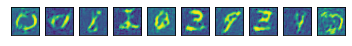

Epoch: [ 3] [  50/ 200] D_loss: 0.64293182, G_loss: 1.54877996
Epoch: [ 3] [ 100/ 200] D_loss: 0.64147061, G_loss: 1.55315673
Epoch: [ 3] [ 150/ 200] D_loss: 0.60913438, G_loss: 1.60814726
Epoch: [ 3] [ 200/ 200] D_loss: 0.64515275, G_loss: 1.86478055


<Figure size 72x720 with 0 Axes>

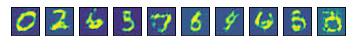

Epoch: [ 4] [  50/ 200] D_loss: 0.70588124, G_loss: 1.56823969
Epoch: [ 4] [ 100/ 200] D_loss: 0.61861807, G_loss: 1.86615813
Epoch: [ 4] [ 150/ 200] D_loss: 0.90047383, G_loss: 1.63339639
Epoch: [ 4] [ 200/ 200] D_loss: 1.13703561, G_loss: 1.45774496


<Figure size 72x720 with 0 Axes>

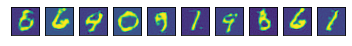

Epoch: [ 5] [  50/ 200] D_loss: 0.85257483, G_loss: 2.16998744
Epoch: [ 5] [ 100/ 200] D_loss: 0.60008425, G_loss: 1.48134267
Epoch: [ 5] [ 150/ 200] D_loss: 0.66786069, G_loss: 1.12167132
Epoch: [ 5] [ 200/ 200] D_loss: 0.59634387, G_loss: 1.36670458


<Figure size 72x720 with 0 Axes>

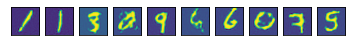

Epoch: [ 6] [  50/ 200] D_loss: 0.56529033, G_loss: 2.11299610
Epoch: [ 6] [ 100/ 200] D_loss: 0.43095618, G_loss: 1.66894019
Epoch: [ 6] [ 150/ 200] D_loss: 0.51174456, G_loss: 1.34217775
Epoch: [ 6] [ 200/ 200] D_loss: 0.60356283, G_loss: 2.34488773


<Figure size 72x720 with 0 Axes>

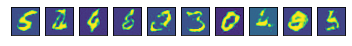

Epoch: [ 7] [  50/ 200] D_loss: 0.53664672, G_loss: 2.12132621
Epoch: [ 7] [ 100/ 200] D_loss: 0.60059172, G_loss: 2.10156155
Epoch: [ 7] [ 150/ 200] D_loss: 0.49069244, G_loss: 1.44572878
Epoch: [ 7] [ 200/ 200] D_loss: 0.62639290, G_loss: 1.86879909


<Figure size 72x720 with 0 Axes>

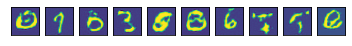

Epoch: [ 8] [  50/ 200] D_loss: 0.49872094, G_loss: 1.55590737
Epoch: [ 8] [ 100/ 200] D_loss: 0.62836152, G_loss: 2.21104097
Epoch: [ 8] [ 150/ 200] D_loss: 0.44157410, G_loss: 2.26474404
Epoch: [ 8] [ 200/ 200] D_loss: 0.92996776, G_loss: 1.66735840


<Figure size 72x720 with 0 Axes>

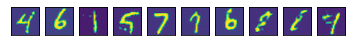

Epoch: [ 9] [  50/ 200] D_loss: 0.56277752, G_loss: 1.90035939
Epoch: [ 9] [ 100/ 200] D_loss: 0.48341638, G_loss: 2.13650060
Epoch: [ 9] [ 150/ 200] D_loss: 0.60896873, G_loss: 1.61226451
Epoch: [ 9] [ 200/ 200] D_loss: 0.52764386, G_loss: 1.41964018


<Figure size 72x720 with 0 Axes>

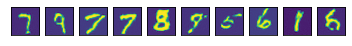

Epoch: [10] [  50/ 200] D_loss: 0.56111205, G_loss: 2.37387753
Epoch: [10] [ 100/ 200] D_loss: 0.52686846, G_loss: 1.55601192
Epoch: [10] [ 150/ 200] D_loss: 0.60113877, G_loss: 2.35550761
Epoch: [10] [ 200/ 200] D_loss: 1.08169711, G_loss: 1.62474334


<Figure size 72x720 with 0 Axes>

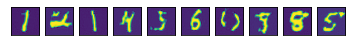

Epoch: [11] [  50/ 200] D_loss: 0.49085206, G_loss: 1.62818885
Epoch: [11] [ 100/ 200] D_loss: 0.59699976, G_loss: 1.73812652
Epoch: [11] [ 150/ 200] D_loss: 0.60243100, G_loss: 0.91538423
Epoch: [11] [ 200/ 200] D_loss: 0.99167395, G_loss: 2.08168173


<Figure size 72x720 with 0 Axes>

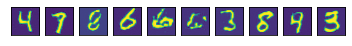

Epoch: [12] [  50/ 200] D_loss: 0.55672640, G_loss: 2.38051200
Epoch: [12] [ 100/ 200] D_loss: 0.66401917, G_loss: 1.72194076
Epoch: [12] [ 150/ 200] D_loss: 0.48320550, G_loss: 1.70397830
Epoch: [12] [ 200/ 200] D_loss: 0.57881021, G_loss: 1.59414673


<Figure size 72x720 with 0 Axes>

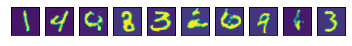

Epoch: [13] [  50/ 200] D_loss: 0.53060848, G_loss: 1.53880537
Epoch: [13] [ 100/ 200] D_loss: 0.57595485, G_loss: 1.87094796
Epoch: [13] [ 150/ 200] D_loss: 0.58252358, G_loss: 1.64142478
Epoch: [13] [ 200/ 200] D_loss: 0.64784443, G_loss: 2.05886817


<Figure size 72x720 with 0 Axes>

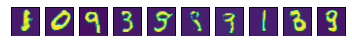

Epoch: [14] [  50/ 200] D_loss: 0.64545822, G_loss: 2.31269193
Epoch: [14] [ 100/ 200] D_loss: 0.77089024, G_loss: 2.03969336
Epoch: [14] [ 150/ 200] D_loss: 0.54955018, G_loss: 1.52481079
Epoch: [14] [ 200/ 200] D_loss: 0.78971767, G_loss: 2.25825787


<Figure size 72x720 with 0 Axes>

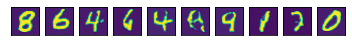

Epoch: [15] [  50/ 200] D_loss: 0.54821157, G_loss: 2.16798306
Epoch: [15] [ 100/ 200] D_loss: 0.74729884, G_loss: 2.13031387
Epoch: [15] [ 150/ 200] D_loss: 0.72909427, G_loss: 2.37314582
Epoch: [15] [ 200/ 200] D_loss: 0.73230302, G_loss: 2.01436639


<Figure size 72x720 with 0 Axes>

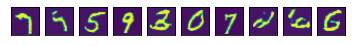

Epoch: [16] [  50/ 200] D_loss: 0.85042953, G_loss: 1.72021329
Epoch: [16] [ 100/ 200] D_loss: 0.59727597, G_loss: 1.51924884
Epoch: [16] [ 150/ 200] D_loss: 0.56523323, G_loss: 1.82862473
Epoch: [16] [ 200/ 200] D_loss: 0.79992801, G_loss: 1.09129131


<Figure size 72x720 with 0 Axes>

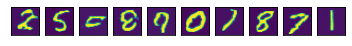

Epoch: [17] [  50/ 200] D_loss: 0.64484060, G_loss: 2.02974725
Epoch: [17] [ 100/ 200] D_loss: 0.78731966, G_loss: 1.46875656
Epoch: [17] [ 150/ 200] D_loss: 0.66166425, G_loss: 2.05409670
Epoch: [17] [ 200/ 200] D_loss: 0.63199073, G_loss: 1.78521609


<Figure size 72x720 with 0 Axes>

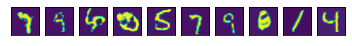

Epoch: [18] [  50/ 200] D_loss: 0.63229287, G_loss: 2.45634723
Epoch: [18] [ 100/ 200] D_loss: 0.72325891, G_loss: 2.22942162
Epoch: [18] [ 150/ 200] D_loss: 0.66151494, G_loss: 2.06997085
Epoch: [18] [ 200/ 200] D_loss: 0.63296783, G_loss: 1.89822495


<Figure size 72x720 with 0 Axes>

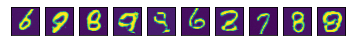

Epoch: [19] [  50/ 200] D_loss: 0.76521128, G_loss: 1.11222637
Epoch: [19] [ 100/ 200] D_loss: 0.70282269, G_loss: 1.84971642
Epoch: [19] [ 150/ 200] D_loss: 0.56872445, G_loss: 2.25946951
Epoch: [19] [ 200/ 200] D_loss: 0.73849529, G_loss: 1.85431564


<Figure size 72x720 with 0 Axes>

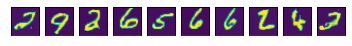

Epoch: [20] [  50/ 200] D_loss: 0.67922258, G_loss: 2.18043971
Epoch: [20] [ 100/ 200] D_loss: 0.66914368, G_loss: 2.33433557
Epoch: [20] [ 150/ 200] D_loss: 0.71673727, G_loss: 1.66124117
Epoch: [20] [ 200/ 200] D_loss: 0.63012427, G_loss: 2.26796341


<Figure size 72x720 with 0 Axes>

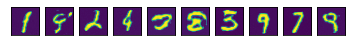

Epoch: [21] [  50/ 200] D_loss: 0.66840506, G_loss: 1.56889224
Epoch: [21] [ 100/ 200] D_loss: 0.58237195, G_loss: 2.34363818
Epoch: [21] [ 150/ 200] D_loss: 0.49845588, G_loss: 2.31712174
Epoch: [21] [ 200/ 200] D_loss: 0.59613347, G_loss: 1.91430998


<Figure size 72x720 with 0 Axes>

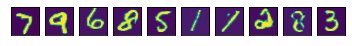

Epoch: [22] [  50/ 200] D_loss: 0.58879149, G_loss: 2.40748143
Epoch: [22] [ 100/ 200] D_loss: 0.55424547, G_loss: 1.42694092
Epoch: [22] [ 150/ 200] D_loss: 0.64630449, G_loss: 1.86323225
Epoch: [22] [ 200/ 200] D_loss: 0.50508666, G_loss: 1.94263864


<Figure size 72x720 with 0 Axes>

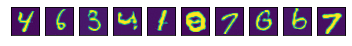

Epoch: [23] [  50/ 200] D_loss: 0.45969602, G_loss: 2.05512762
Epoch: [23] [ 100/ 200] D_loss: 0.59701896, G_loss: 2.32877159
Epoch: [23] [ 150/ 200] D_loss: 0.70650035, G_loss: 1.50373447
Epoch: [23] [ 200/ 200] D_loss: 0.61125976, G_loss: 1.65875816


<Figure size 72x720 with 0 Axes>

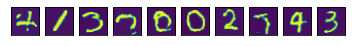

Epoch: [24] [  50/ 200] D_loss: 0.52791274, G_loss: 2.06732273
Epoch: [24] [ 100/ 200] D_loss: 0.70465434, G_loss: 1.61808372
Epoch: [24] [ 150/ 200] D_loss: 0.58093596, G_loss: 2.18611789
Epoch: [24] [ 200/ 200] D_loss: 0.52335995, G_loss: 2.05909300


<Figure size 72x720 with 0 Axes>

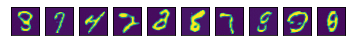

Epoch: [25] [  50/ 200] D_loss: 0.48999128, G_loss: 2.24230599
Epoch: [25] [ 100/ 200] D_loss: 0.58046156, G_loss: 1.64441776
Epoch: [25] [ 150/ 200] D_loss: 0.44465509, G_loss: 2.27212071
Epoch: [25] [ 200/ 200] D_loss: 0.59745932, G_loss: 1.83581257


<Figure size 72x720 with 0 Axes>

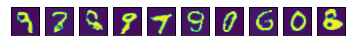

Epoch: [26] [  50/ 200] D_loss: 0.55367804, G_loss: 2.03044033
Epoch: [26] [ 100/ 200] D_loss: 0.49190813, G_loss: 2.08294010
Epoch: [26] [ 150/ 200] D_loss: 0.89446074, G_loss: 2.20027494
Epoch: [26] [ 200/ 200] D_loss: 0.53513014, G_loss: 1.65273869


<Figure size 72x720 with 0 Axes>

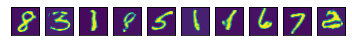

Epoch: [27] [  50/ 200] D_loss: 0.46787906, G_loss: 1.93731713
Epoch: [27] [ 100/ 200] D_loss: 0.58910638, G_loss: 1.95221221
Epoch: [27] [ 150/ 200] D_loss: 0.67211258, G_loss: 1.59936762
Epoch: [27] [ 200/ 200] D_loss: 0.55473655, G_loss: 2.65261078


<Figure size 72x720 with 0 Axes>

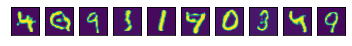

Epoch: [28] [  50/ 200] D_loss: 0.39405149, G_loss: 2.34359717
Epoch: [28] [ 100/ 200] D_loss: 0.52934122, G_loss: 3.17468715
Epoch: [28] [ 150/ 200] D_loss: 1.02603185, G_loss: 2.22895479
Epoch: [28] [ 200/ 200] D_loss: 0.52092749, G_loss: 1.83086348


<Figure size 72x720 with 0 Axes>

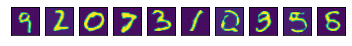

Epoch: [29] [  50/ 200] D_loss: 0.43467557, G_loss: 1.99665821
Epoch: [29] [ 100/ 200] D_loss: 0.59602129, G_loss: 2.28759742
Epoch: [29] [ 150/ 200] D_loss: 0.57368791, G_loss: 2.20211697
Epoch: [29] [ 200/ 200] D_loss: 0.67314506, G_loss: 2.64957070


<Figure size 72x720 with 0 Axes>

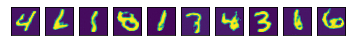

Epoch: [30] [  50/ 200] D_loss: 0.43727607, G_loss: 2.06624436
Epoch: [30] [ 100/ 200] D_loss: 0.46073967, G_loss: 2.37540245
Epoch: [30] [ 150/ 200] D_loss: 0.60534269, G_loss: 2.08237433
Epoch: [30] [ 200/ 200] D_loss: 0.48199362, G_loss: 2.18252540


<Figure size 72x720 with 0 Axes>

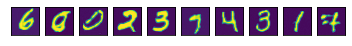

Avg one epoch time: 12.58, total 30 epochs time: 386.71
Training finish!... save training results


In [ ]:
params = {'beta1': 0.5, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':30}
if torch.cuda.is_available():
  params['gpu'] = True
else:
  params['gpu'] = False
params['z_dim'] = 12

gan = GAN(params)
gan.train()

<Figure size 2880x2880 with 0 Axes>

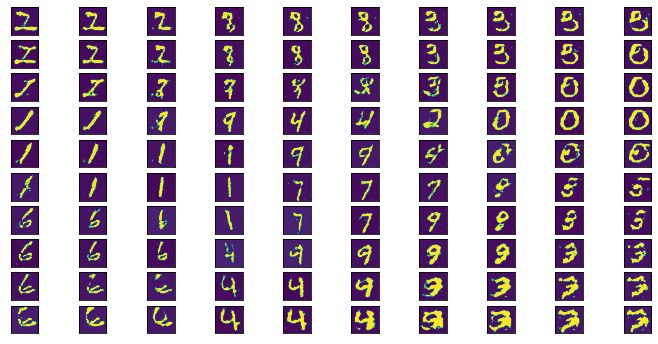

In [ ]:
mtx_size = 10
[x,y] = np.meshgrid(np.linspace(0,1,10),np.linspace(1,0,10))
embedding = np.stack((x.ravel(),y.ravel()))
embedding = torch.tensor(embedding).T.cuda()
embedding = embedding.type(torch.cuda.FloatTensor)
recons = gan.G(embedding)
recons = recons.detach().cpu().numpy()

recons.shape
plt.figure(figsize=(40, 40))
fig,ax = plt.subplots(mtx_size,mtx_size)

i = 0
for x in range(mtx_size):
  for y in range(mtx_size):
    i = x*mtx_size + y
    ax[x][y].imshow(np.reshape(recons[i,],(28,28)))
    ax[x][y].get_xaxis().set_visible(False)
    ax[x][y].get_yaxis().set_visible(False)